# Afriat

In [1]:
ood_seed = 2

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('12', 'Pericentral', 'Infected')


Removed datapoint: 179

train         15063
validation     3811
ood             179
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 46%|████▌     | 8793/19053 [00:00<00:00, 87927.57it/s]

 92%|█████████▏| 17586/19053 [00:00<00:00, 87330.87it/s]

100%|██████████| 19053/19053 [00:00<00:00, 87275.98it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1044464.58it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 475.65it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:29<3:18:39, 29.87s/it]

Epoch 1/400:   0%|          | 1/400 [00:29<3:18:39, 29.87s/it, v_num=1, recon=3.96e+3, r2_mean=0.209, adv_loss=3.31, acc_pert=0.261, acc_zone=0.733, acc_status_control=0.494]

Epoch 2/400:   0%|          | 1/400 [00:29<3:18:39, 29.87s/it, v_num=1, recon=3.96e+3, r2_mean=0.209, adv_loss=3.31, acc_pert=0.261, acc_zone=0.733, acc_status_control=0.494]

Epoch 2/400:   0%|          | 2/400 [00:39<1:57:46, 17.76s/it, v_num=1, recon=3.96e+3, r2_mean=0.209, adv_loss=3.31, acc_pert=0.261, acc_zone=0.733, acc_status_control=0.494]

Epoch 2/400:   0%|          | 2/400 [00:39<1:57:46, 17.76s/it, v_num=1, recon=3.25e+3, r2_mean=0.616, adv_loss=2.89, acc_pert=0.372, acc_zone=0.807, acc_status_control=0.638]

Epoch 3/400:   0%|          | 2/400 [00:39<1:57:46, 17.76s/it, v_num=1, recon=3.25e+3, r2_mean=0.616, adv_loss=2.89, acc_pert=0.372, acc_zone=0.807, acc_status_control=0.638]

Epoch 3/400:   1%|          | 3/400 [00:55<1:53:24, 17.14s/it, v_num=1, recon=3.25e+3, r2_mean=0.616, adv_loss=2.89, acc_pert=0.372, acc_zone=0.807, acc_status_control=0.638]

Epoch 3/400:   1%|          | 3/400 [00:55<1:53:24, 17.14s/it, v_num=1, recon=3.2e+3, r2_mean=0.723, adv_loss=2.8, acc_pert=0.389, acc_zone=0.815, acc_status_control=0.627]  

Epoch 4/400:   1%|          | 3/400 [00:55<1:53:24, 17.14s/it, v_num=1, recon=3.2e+3, r2_mean=0.723, adv_loss=2.8, acc_pert=0.389, acc_zone=0.815, acc_status_control=0.627]

Epoch 4/400:   1%|          | 4/400 [01:24<2:23:25, 21.73s/it, v_num=1, recon=3.2e+3, r2_mean=0.723, adv_loss=2.8, acc_pert=0.389, acc_zone=0.815, acc_status_control=0.627]

Epoch 4/400:   1%|          | 4/400 [01:24<2:23:25, 21.73s/it, v_num=1, recon=3.18e+3, r2_mean=0.757, adv_loss=2.8, acc_pert=0.39, acc_zone=0.82, acc_status_control=0.621] 

Epoch 5/400:   1%|          | 4/400 [01:24<2:23:25, 21.73s/it, v_num=1, recon=3.18e+3, r2_mean=0.757, adv_loss=2.8, acc_pert=0.39, acc_zone=0.82, acc_status_control=0.621]

Epoch 5/400:   1%|▏         | 5/400 [01:33<1:53:44, 17.28s/it, v_num=1, recon=3.18e+3, r2_mean=0.757, adv_loss=2.8, acc_pert=0.39, acc_zone=0.82, acc_status_control=0.621]

Epoch 5/400:   1%|▏         | 5/400 [01:33<1:53:44, 17.28s/it, v_num=1, recon=3.16e+3, r2_mean=0.778, adv_loss=2.56, acc_pert=0.49, acc_zone=0.836, acc_status_control=0.626]

Epoch 6/400:   1%|▏         | 5/400 [01:33<1:53:44, 17.28s/it, v_num=1, recon=3.16e+3, r2_mean=0.778, adv_loss=2.56, acc_pert=0.49, acc_zone=0.836, acc_status_control=0.626]

Epoch 6/400:   2%|▏         | 6/400 [01:43<1:35:50, 14.59s/it, v_num=1, recon=3.16e+3, r2_mean=0.778, adv_loss=2.56, acc_pert=0.49, acc_zone=0.836, acc_status_control=0.626]

Epoch 6/400:   2%|▏         | 6/400 [01:43<1:35:50, 14.59s/it, v_num=1, recon=3.15e+3, r2_mean=0.792, adv_loss=2.35, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.626]

Epoch 7/400:   2%|▏         | 6/400 [01:43<1:35:50, 14.59s/it, v_num=1, recon=3.15e+3, r2_mean=0.792, adv_loss=2.35, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.626]

Epoch 7/400:   2%|▏         | 7/400 [01:52<1:24:21, 12.88s/it, v_num=1, recon=3.15e+3, r2_mean=0.792, adv_loss=2.35, acc_pert=0.556, acc_zone=0.841, acc_status_control=0.626]

Epoch 7/400:   2%|▏         | 7/400 [01:52<1:24:21, 12.88s/it, v_num=1, recon=3.14e+3, r2_mean=0.8, adv_loss=2.23, acc_pert=0.593, acc_zone=0.849, acc_status_control=0.63]   

Epoch 8/400:   2%|▏         | 7/400 [01:52<1:24:21, 12.88s/it, v_num=1, recon=3.14e+3, r2_mean=0.8, adv_loss=2.23, acc_pert=0.593, acc_zone=0.849, acc_status_control=0.63]

Epoch 8/400:   2%|▏         | 8/400 [02:01<1:16:42, 11.74s/it, v_num=1, recon=3.14e+3, r2_mean=0.8, adv_loss=2.23, acc_pert=0.593, acc_zone=0.849, acc_status_control=0.63]

Epoch 8/400:   2%|▏         | 8/400 [02:01<1:16:42, 11.74s/it, v_num=1, recon=3.13e+3, r2_mean=0.807, adv_loss=2.16, acc_pert=0.618, acc_zone=0.851, acc_status_control=0.632]

Epoch 9/400:   2%|▏         | 8/400 [02:01<1:16:42, 11.74s/it, v_num=1, recon=3.13e+3, r2_mean=0.807, adv_loss=2.16, acc_pert=0.618, acc_zone=0.851, acc_status_control=0.632]

Epoch 9/400:   2%|▏         | 9/400 [02:11<1:11:48, 11.02s/it, v_num=1, recon=3.13e+3, r2_mean=0.807, adv_loss=2.16, acc_pert=0.618, acc_zone=0.851, acc_status_control=0.632]

Epoch 9/400:   2%|▏         | 9/400 [02:11<1:11:48, 11.02s/it, v_num=1, recon=3.13e+3, r2_mean=0.81, adv_loss=2.12, acc_pert=0.636, acc_zone=0.856, acc_status_control=0.632] 

Epoch 10/400:   2%|▏         | 9/400 [02:11<1:11:48, 11.02s/it, v_num=1, recon=3.13e+3, r2_mean=0.81, adv_loss=2.12, acc_pert=0.636, acc_zone=0.856, acc_status_control=0.632]


disnt_basal = 1.2437355712693192

disnt_after = 1.908301890943235

val_r2_mean = 0.8146261652312106

val_r2_var = 0.20407778559181558


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [03:00<2:28:17, 22.81s/it, v_num=1, recon=3.13e+3, r2_mean=0.81, adv_loss=2.12, acc_pert=0.636, acc_zone=0.856, acc_status_control=0.632]

Epoch 10/400:   2%|▎         | 10/400 [03:00<2:28:17, 22.81s/it, v_num=1, recon=3.12e+3, r2_mean=0.814, adv_loss=2.07, acc_pert=0.643, acc_zone=0.857, acc_status_control=0.63, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [03:00<2:28:17, 22.81s/it, v_num=1, recon=3.12e+3, r2_mean=0.814, adv_loss=2.07, acc_pert=0.643, acc_zone=0.857, acc_status_control=0.63, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [03:10<2:02:09, 18.84s/it, v_num=1, recon=3.12e+3, r2_mean=0.814, adv_loss=2.07, acc_pert=0.643, acc_zone=0.857, acc_status_control=0.63, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [03:10<2:02:09, 18.84s/it, v_num=1, recon=3.11e+3, r2_mean=0.819, adv_loss=2.03, acc_pert=0.658, acc_zone=0.858, acc_status_control=0.641, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [03:10<2:02:09, 18.84s/it, v_num=1, recon=3.11e+3, r2_mean=0.819, adv_loss=2.03, acc_pert=0.658, acc_zone=0.858, acc_status_control=0.641, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [03:21<1:46:37, 16.49s/it, v_num=1, recon=3.11e+3, r2_mean=0.819, adv_loss=2.03, acc_pert=0.658, acc_zone=0.858, acc_status_control=0.641, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [03:21<1:46:37, 16.49s/it, v_num=1, recon=3.11e+3, r2_mean=0.819, adv_loss=2.02, acc_pert=0.664, acc_zone=0.857, acc_status_control=0.632, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [03:21<1:46:37, 16.49s/it, v_num=1, recon=3.11e+3, r2_mean=0.819, adv_loss=2.02, acc_pert=0.664, acc_zone=0.857, acc_status_control=0.632, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [03:30<1:32:30, 14.34s/it, v_num=1, recon=3.11e+3, r2_mean=0.819, adv_loss=2.02, acc_pert=0.664, acc_zone=0.857, acc_status_control=0.632, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [03:30<1:32:30, 14.34s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=1.97, acc_pert=0.677, acc_zone=0.86, acc_status_control=0.636, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]  

Epoch 14/400:   3%|▎         | 13/400 [03:30<1:32:30, 14.34s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=1.97, acc_pert=0.677, acc_zone=0.86, acc_status_control=0.636, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [03:40<1:22:34, 12.84s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=1.97, acc_pert=0.677, acc_zone=0.86, acc_status_control=0.636, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [03:40<1:22:34, 12.84s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=1.96, acc_pert=0.679, acc_zone=0.861, acc_status_control=0.639, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [03:40<1:22:34, 12.84s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=1.96, acc_pert=0.679, acc_zone=0.861, acc_status_control=0.639, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [03:49<1:15:53, 11.83s/it, v_num=1, recon=3.1e+3, r2_mean=0.822, adv_loss=1.96, acc_pert=0.679, acc_zone=0.861, acc_status_control=0.639, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [03:49<1:15:53, 11.83s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.93, acc_pert=0.692, acc_zone=0.861, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [03:49<1:15:53, 11.83s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.93, acc_pert=0.692, acc_zone=0.861, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:59<1:11:05, 11.11s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.93, acc_pert=0.692, acc_zone=0.861, acc_status_control=0.644, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [03:59<1:11:05, 11.11s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.93, acc_pert=0.699, acc_zone=0.861, acc_status_control=0.64, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan] 

Epoch 17/400:   4%|▍         | 16/400 [03:59<1:11:05, 11.11s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.93, acc_pert=0.699, acc_zone=0.861, acc_status_control=0.64, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [04:08<1:07:34, 10.59s/it, v_num=1, recon=3.09e+3, r2_mean=0.823, adv_loss=1.93, acc_pert=0.699, acc_zone=0.861, acc_status_control=0.64, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [04:08<1:07:34, 10.59s/it, v_num=1, recon=3.09e+3, r2_mean=0.826, adv_loss=1.94, acc_pert=0.692, acc_zone=0.86, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [04:08<1:07:34, 10.59s/it, v_num=1, recon=3.09e+3, r2_mean=0.826, adv_loss=1.94, acc_pert=0.692, acc_zone=0.86, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [04:17<1:05:08, 10.23s/it, v_num=1, recon=3.09e+3, r2_mean=0.826, adv_loss=1.94, acc_pert=0.692, acc_zone=0.86, acc_status_control=0.643, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [04:17<1:05:08, 10.23s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=1.93, acc_pert=0.695, acc_zone=0.86, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [04:17<1:05:08, 10.23s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=1.93, acc_pert=0.695, acc_zone=0.86, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [04:27<1:03:24,  9.99s/it, v_num=1, recon=3.08e+3, r2_mean=0.825, adv_loss=1.93, acc_pert=0.695, acc_zone=0.86, acc_status_control=0.651, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [04:27<1:03:24,  9.99s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=1.91, acc_pert=0.694, acc_zone=0.859, acc_status_control=0.649, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [04:27<1:03:24,  9.99s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=1.91, acc_pert=0.694, acc_zone=0.859, acc_status_control=0.649, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]


disnt_basal = 1.2483782547319622

disnt_after = 1.8851782025972197

val_r2_mean = 0.8289941594052329

val_r2_var = 0.23209226651226528

Epoch 20/400:   5%|▌         | 20/400 [05:17<2:20:37, 22.21s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=1.91, acc_pert=0.694, acc_zone=0.859, acc_status_control=0.649, val_recon=3.11e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.815, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [05:17<2:20:37, 22.21s/it, v_num=1, recon=3.07e+3, r2_mean=0.828, adv_loss=1.89, acc_pert=0.704, acc_zone=0.859, acc_status_control=0.652, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 21/400:   5%|▌         | 20/400 [05:17<2:20:37, 22.21s/it, v_num=1, recon=3.07e+3, r2_mean=0.828, adv_loss=1.89, acc_pert=0.704, acc_zone=0.859, acc_status_control=0.652, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [05:28<1:58:18, 18.73s/it, v_num=1, recon=3.07e+3, r2_mean=0.828, adv_loss=1.89, acc_pert=0.704, acc_zone=0.859, acc_status_control=0.652, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [05:28<1:58:18, 18.73s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.92, acc_pert=0.695, acc_zone=0.859, acc_status_control=0.651, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan] 

Epoch 22/400:   5%|▌         | 21/400 [05:28<1:58:18, 18.73s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.92, acc_pert=0.695, acc_zone=0.859, acc_status_control=0.651, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [05:37<1:40:19, 15.93s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.92, acc_pert=0.695, acc_zone=0.859, acc_status_control=0.651, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [05:37<1:40:19, 15.93s/it, v_num=1, recon=3.07e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.692, acc_zone=0.86, acc_status_control=0.649, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 23/400:   6%|▌         | 22/400 [05:37<1:40:19, 15.93s/it, v_num=1, recon=3.07e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.692, acc_zone=0.86, acc_status_control=0.649, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [05:47<1:27:57, 14.00s/it, v_num=1, recon=3.07e+3, r2_mean=0.829, adv_loss=1.92, acc_pert=0.692, acc_zone=0.86, acc_status_control=0.649, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [05:47<1:27:57, 14.00s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.92, acc_pert=0.687, acc_zone=0.858, acc_status_control=0.655, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [05:47<1:27:57, 14.00s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.92, acc_pert=0.687, acc_zone=0.858, acc_status_control=0.655, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [05:56<1:19:17, 12.65s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.92, acc_pert=0.687, acc_zone=0.858, acc_status_control=0.655, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [05:56<1:19:17, 12.65s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.697, acc_zone=0.855, acc_status_control=0.654, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [05:56<1:19:17, 12.65s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.697, acc_zone=0.855, acc_status_control=0.654, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [06:06<1:13:00, 11.68s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.91, acc_pert=0.697, acc_zone=0.855, acc_status_control=0.654, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [06:06<1:13:00, 11.68s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.93, acc_pert=0.692, acc_zone=0.854, acc_status_control=0.655, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [06:06<1:13:00, 11.68s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.93, acc_pert=0.692, acc_zone=0.854, acc_status_control=0.655, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [06:15<1:08:38, 11.01s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.93, acc_pert=0.692, acc_zone=0.854, acc_status_control=0.655, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [06:15<1:08:38, 11.01s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=1.92, acc_pert=0.691, acc_zone=0.854, acc_status_control=0.656, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [06:15<1:08:38, 11.01s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=1.92, acc_pert=0.691, acc_zone=0.854, acc_status_control=0.656, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [06:25<1:05:25, 10.52s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=1.92, acc_pert=0.691, acc_zone=0.854, acc_status_control=0.656, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [06:25<1:05:25, 10.52s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=1.93, acc_pert=0.686, acc_zone=0.853, acc_status_control=0.655, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [06:25<1:05:25, 10.52s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=1.93, acc_pert=0.686, acc_zone=0.853, acc_status_control=0.655, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [06:34<1:03:09, 10.19s/it, v_num=1, recon=3.05e+3, r2_mean=0.834, adv_loss=1.93, acc_pert=0.686, acc_zone=0.853, acc_status_control=0.655, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [06:34<1:03:09, 10.19s/it, v_num=1, recon=3.05e+3, r2_mean=0.833, adv_loss=1.91, acc_pert=0.693, acc_zone=0.856, acc_status_control=0.66, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan] 

Epoch 29/400:   7%|▋         | 28/400 [06:34<1:03:09, 10.19s/it, v_num=1, recon=3.05e+3, r2_mean=0.833, adv_loss=1.91, acc_pert=0.693, acc_zone=0.856, acc_status_control=0.66, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [06:50<1:14:24, 12.03s/it, v_num=1, recon=3.05e+3, r2_mean=0.833, adv_loss=1.91, acc_pert=0.693, acc_zone=0.856, acc_status_control=0.66, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [06:50<1:14:24, 12.03s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.69, acc_zone=0.854, acc_status_control=0.663, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [06:50<1:14:24, 12.03s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.69, acc_zone=0.854, acc_status_control=0.663, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2303031410540863

disnt_after = 1.877187846211902

val_r2_mean = 0.8273485582138262

val_r2_var = 0.26174765095639263


Epoch 00029: cpa_metric reached. Module best state updated.


Epoch 30/400:   8%|▊         | 30/400 [07:54<2:50:28, 27.64s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.93, acc_pert=0.69, acc_zone=0.854, acc_status_control=0.663, val_recon=3.08e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [07:54<2:50:28, 27.64s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=1.92, acc_pert=0.692, acc_zone=0.856, acc_status_control=0.658, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [07:54<2:50:28, 27.64s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=1.92, acc_pert=0.692, acc_zone=0.856, acc_status_control=0.658, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [08:10<2:27:59, 24.06s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=1.92, acc_pert=0.692, acc_zone=0.856, acc_status_control=0.658, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [08:10<2:27:59, 24.06s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.693, acc_zone=0.854, acc_status_control=0.655, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [08:10<2:27:59, 24.06s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.693, acc_zone=0.854, acc_status_control=0.655, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [08:20<2:00:49, 19.70s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.91, acc_pert=0.693, acc_zone=0.854, acc_status_control=0.655, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [08:20<2:00:49, 19.70s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=1.91, acc_pert=0.694, acc_zone=0.854, acc_status_control=0.659, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [08:20<2:00:49, 19.70s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=1.91, acc_pert=0.694, acc_zone=0.854, acc_status_control=0.659, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [08:29<1:41:40, 16.62s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=1.91, acc_pert=0.694, acc_zone=0.854, acc_status_control=0.659, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [08:29<1:41:40, 16.62s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.92, acc_pert=0.692, acc_zone=0.855, acc_status_control=0.662, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [08:29<1:41:40, 16.62s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.92, acc_pert=0.692, acc_zone=0.855, acc_status_control=0.662, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [08:39<1:28:14, 14.47s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.92, acc_pert=0.692, acc_zone=0.855, acc_status_control=0.662, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [08:39<1:28:14, 14.47s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.94, acc_pert=0.679, acc_zone=0.853, acc_status_control=0.659, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [08:39<1:28:14, 14.47s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.94, acc_pert=0.679, acc_zone=0.853, acc_status_control=0.659, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [08:48<1:18:47, 12.95s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.94, acc_pert=0.679, acc_zone=0.853, acc_status_control=0.659, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [08:48<1:18:47, 12.95s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=1.95, acc_pert=0.682, acc_zone=0.855, acc_status_control=0.66, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 36/400:   9%|▉         | 35/400 [08:48<1:18:47, 12.95s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=1.95, acc_pert=0.682, acc_zone=0.855, acc_status_control=0.66, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [08:57<1:12:09, 11.90s/it, v_num=1, recon=3.03e+3, r2_mean=0.836, adv_loss=1.95, acc_pert=0.682, acc_zone=0.855, acc_status_control=0.66, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [08:57<1:12:09, 11.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=1.96, acc_pert=0.684, acc_zone=0.85, acc_status_control=0.662, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [08:57<1:12:09, 11.90s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=1.96, acc_pert=0.684, acc_zone=0.85, acc_status_control=0.662, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [09:07<1:07:23, 11.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.835, adv_loss=1.96, acc_pert=0.684, acc_zone=0.85, acc_status_control=0.662, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [09:07<1:07:23, 11.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=1.95, acc_pert=0.689, acc_zone=0.85, acc_status_control=0.664, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [09:07<1:07:23, 11.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=1.95, acc_pert=0.689, acc_zone=0.85, acc_status_control=0.664, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [09:16<1:04:17, 10.66s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=1.95, acc_pert=0.689, acc_zone=0.85, acc_status_control=0.664, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [09:16<1:04:17, 10.66s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=1.95, acc_pert=0.684, acc_zone=0.852, acc_status_control=0.661, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [09:16<1:04:17, 10.66s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=1.95, acc_pert=0.684, acc_zone=0.852, acc_status_control=0.661, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [09:26<1:01:57, 10.30s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=1.95, acc_pert=0.684, acc_zone=0.852, acc_status_control=0.661, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [09:26<1:01:57, 10.30s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=1.96, acc_pert=0.679, acc_zone=0.853, acc_status_control=0.66, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 40/400:  10%|▉         | 39/400 [09:26<1:01:57, 10.30s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=1.96, acc_pert=0.679, acc_zone=0.853, acc_status_control=0.66, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2132142608408194

disnt_after = 1.882038424332406

val_r2_mean = 0.8285576578175075

val_r2_var = 0.2605968415155771


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [10:21<2:21:45, 23.63s/it, v_num=1, recon=3.02e+3, r2_mean=0.837, adv_loss=1.96, acc_pert=0.679, acc_zone=0.853, acc_status_control=0.66, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [10:21<2:21:45, 23.63s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=1.97, acc_pert=0.682, acc_zone=0.85, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [10:21<2:21:45, 23.63s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=1.97, acc_pert=0.682, acc_zone=0.85, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [10:33<2:00:31, 20.14s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=1.97, acc_pert=0.682, acc_zone=0.85, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [10:33<2:00:31, 20.14s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.99, acc_pert=0.668, acc_zone=0.851, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [10:33<2:00:31, 20.14s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.99, acc_pert=0.668, acc_zone=0.851, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [10:42<1:41:33, 17.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.99, acc_pert=0.668, acc_zone=0.851, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [10:42<1:41:33, 17.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2, acc_pert=0.664, acc_zone=0.851, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]   

Epoch 43/400:  10%|█         | 42/400 [10:42<1:41:33, 17.02s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2, acc_pert=0.664, acc_zone=0.851, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [10:52<1:27:58, 14.79s/it, v_num=1, recon=3.01e+3, r2_mean=0.836, adv_loss=2, acc_pert=0.664, acc_zone=0.851, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [10:52<1:27:58, 14.79s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.01, acc_pert=0.665, acc_zone=0.851, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [10:52<1:27:58, 14.79s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.01, acc_pert=0.665, acc_zone=0.851, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [11:01<1:18:11, 13.18s/it, v_num=1, recon=3.01e+3, r2_mean=0.835, adv_loss=2.01, acc_pert=0.665, acc_zone=0.851, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [11:01<1:18:11, 13.18s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.02, acc_pert=0.659, acc_zone=0.854, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]   

Epoch 45/400:  11%|█         | 44/400 [11:01<1:18:11, 13.18s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.02, acc_pert=0.659, acc_zone=0.854, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [11:11<1:11:16, 12.05s/it, v_num=1, recon=3e+3, r2_mean=0.835, adv_loss=2.02, acc_pert=0.659, acc_zone=0.854, acc_status_control=0.663, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [11:11<1:11:16, 12.05s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.02, acc_pert=0.662, acc_zone=0.853, acc_status_control=0.66, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [11:11<1:11:16, 12.05s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.02, acc_pert=0.662, acc_zone=0.853, acc_status_control=0.66, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [11:20<1:06:12, 11.22s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.02, acc_pert=0.662, acc_zone=0.853, acc_status_control=0.66, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [11:20<1:06:12, 11.22s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.03, acc_pert=0.653, acc_zone=0.849, acc_status_control=0.664, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [11:20<1:06:12, 11.22s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.03, acc_pert=0.653, acc_zone=0.849, acc_status_control=0.664, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [11:29<1:02:47, 10.67s/it, v_num=1, recon=3e+3, r2_mean=0.838, adv_loss=2.03, acc_pert=0.653, acc_zone=0.849, acc_status_control=0.664, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [11:29<1:02:47, 10.67s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.646, acc_zone=0.85, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan] 

Epoch 48/400:  12%|█▏        | 47/400 [11:29<1:02:47, 10.67s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.646, acc_zone=0.85, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [11:39<1:00:12, 10.26s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.646, acc_zone=0.85, acc_status_control=0.662, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [11:39<1:00:12, 10.26s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.06, acc_pert=0.639, acc_zone=0.848, acc_status_control=0.664, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [11:39<1:00:12, 10.26s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.06, acc_pert=0.639, acc_zone=0.848, acc_status_control=0.664, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [11:48<58:19,  9.97s/it, v_num=1, recon=3e+3, r2_mean=0.837, adv_loss=2.06, acc_pert=0.639, acc_zone=0.848, acc_status_control=0.664, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]  

Epoch 49/400:  12%|█▏        | 49/400 [11:48<58:19,  9.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.633, acc_zone=0.847, acc_status_control=0.66, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [11:48<58:19,  9.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.633, acc_zone=0.847, acc_status_control=0.66, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2190187097419534

disnt_after = 1.8773201112567512

val_r2_mean = 0.8346946712609017

val_r2_var = 0.2813984553422789

Epoch 50/400:  12%|█▎        | 50/400 [12:36<2:05:05, 21.44s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.633, acc_zone=0.847, acc_status_control=0.66, val_recon=3.02e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.829, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [12:36<2:05:05, 21.44s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.625, acc_zone=0.851, acc_status_control=0.656, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]  

Epoch 51/400:  12%|█▎        | 50/400 [12:36<2:05:05, 21.44s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.625, acc_zone=0.851, acc_status_control=0.656, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [12:46<1:44:19, 17.93s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=2.08, acc_pert=0.625, acc_zone=0.851, acc_status_control=0.656, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [12:46<1:44:19, 17.93s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.08, acc_pert=0.628, acc_zone=0.85, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 52/400:  13%|█▎        | 51/400 [12:46<1:44:19, 17.93s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.08, acc_pert=0.628, acc_zone=0.85, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [13:01<1:38:47, 17.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.839, adv_loss=2.08, acc_pert=0.628, acc_zone=0.85, acc_status_control=0.665, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [13:01<1:38:47, 17.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.08, acc_pert=0.633, acc_zone=0.848, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [13:01<1:38:47, 17.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.08, acc_pert=0.633, acc_zone=0.848, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [13:10<1:25:32, 14.79s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=2.08, acc_pert=0.633, acc_zone=0.848, acc_status_control=0.664, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [13:10<1:25:32, 14.79s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.07, acc_pert=0.632, acc_zone=0.849, acc_status_control=0.663, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [13:10<1:25:32, 14.79s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.07, acc_pert=0.632, acc_zone=0.849, acc_status_control=0.663, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [13:20<1:15:54, 13.16s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.07, acc_pert=0.632, acc_zone=0.849, acc_status_control=0.663, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [13:20<1:15:54, 13.16s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.1, acc_pert=0.623, acc_zone=0.848, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan] 

Epoch 55/400:  14%|█▎        | 54/400 [13:20<1:15:54, 13.16s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.1, acc_pert=0.623, acc_zone=0.848, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [13:29<1:09:29, 12.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.1, acc_pert=0.623, acc_zone=0.848, acc_status_control=0.661, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [13:29<1:09:29, 12.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.1, acc_pert=0.62, acc_zone=0.846, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]  

Epoch 56/400:  14%|█▍        | 55/400 [13:29<1:09:29, 12.09s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.1, acc_pert=0.62, acc_zone=0.846, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [13:39<1:04:42, 11.29s/it, v_num=1, recon=2.98e+3, r2_mean=0.839, adv_loss=2.1, acc_pert=0.62, acc_zone=0.846, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [13:39<1:04:42, 11.29s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.1, acc_pert=0.62, acc_zone=0.847, acc_status_control=0.659, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [13:39<1:04:42, 11.29s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.1, acc_pert=0.62, acc_zone=0.847, acc_status_control=0.659, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [13:48<1:01:16, 10.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.84, adv_loss=2.1, acc_pert=0.62, acc_zone=0.847, acc_status_control=0.659, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [13:48<1:01:16, 10.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.62, acc_zone=0.846, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [13:48<1:01:16, 10.72s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.62, acc_zone=0.846, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [13:58<58:48, 10.32s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=2.11, acc_pert=0.62, acc_zone=0.846, acc_status_control=0.66, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]  

Epoch 58/400:  14%|█▍        | 58/400 [13:58<58:48, 10.32s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.617, acc_zone=0.847, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [13:58<58:48, 10.32s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.617, acc_zone=0.847, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [14:07<57:04, 10.04s/it, v_num=1, recon=2.98e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.617, acc_zone=0.847, acc_status_control=0.662, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [14:07<57:04, 10.04s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.611, acc_zone=0.844, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [14:07<57:04, 10.04s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.611, acc_zone=0.844, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.2096902594255488

disnt_after = 1.8760784032809468

val_r2_mean = 0.8276401892284501

val_r2_var = 0.28283225525549216


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [15:01<2:12:14, 23.34s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.611, acc_zone=0.844, acc_status_control=0.657, val_recon=3e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.835, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [15:01<2:12:14, 23.34s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.12, acc_pert=0.615, acc_zone=0.849, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [15:01<2:12:14, 23.34s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.12, acc_pert=0.615, acc_zone=0.849, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [15:15<1:56:12, 20.57s/it, v_num=1, recon=2.97e+3, r2_mean=0.84, adv_loss=2.12, acc_pert=0.615, acc_zone=0.849, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [15:15<1:56:12, 20.57s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.621, acc_zone=0.847, acc_status_control=0.66, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [15:15<1:56:12, 20.57s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.621, acc_zone=0.847, acc_status_control=0.66, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [15:25<1:37:12, 17.26s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.11, acc_pert=0.621, acc_zone=0.847, acc_status_control=0.66, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [15:25<1:37:12, 17.26s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.614, acc_zone=0.847, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [15:25<1:37:12, 17.26s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.614, acc_zone=0.847, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [15:34<1:23:45, 14.91s/it, v_num=1, recon=2.97e+3, r2_mean=0.839, adv_loss=2.12, acc_pert=0.614, acc_zone=0.847, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [15:34<1:23:45, 14.91s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.613, acc_zone=0.847, acc_status_control=0.662, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [15:34<1:23:45, 14.91s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.613, acc_zone=0.847, acc_status_control=0.662, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [15:52<1:28:25, 15.79s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.613, acc_zone=0.847, acc_status_control=0.662, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [15:52<1:28:25, 15.79s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.609, acc_zone=0.845, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [15:52<1:28:25, 15.79s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.609, acc_zone=0.845, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [16:02<1:17:31, 13.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.13, acc_pert=0.609, acc_zone=0.845, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [16:02<1:17:31, 13.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.604, acc_zone=0.845, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [16:02<1:17:31, 13.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.604, acc_zone=0.845, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [16:11<1:09:56, 12.56s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.604, acc_zone=0.845, acc_status_control=0.653, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [16:11<1:09:56, 12.56s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.609, acc_zone=0.846, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [16:11<1:09:56, 12.56s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.609, acc_zone=0.846, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [16:21<1:04:33, 11.63s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.609, acc_zone=0.846, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [16:21<1:04:33, 11.63s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.605, acc_zone=0.846, acc_status_control=0.657, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [16:21<1:04:33, 11.63s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.605, acc_zone=0.846, acc_status_control=0.657, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [16:30<1:00:49, 10.99s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.14, acc_pert=0.605, acc_zone=0.846, acc_status_control=0.657, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [16:30<1:00:49, 10.99s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.606, acc_zone=0.842, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [16:30<1:00:49, 10.99s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.606, acc_zone=0.842, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [16:40<59:36, 10.81s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.13, acc_pert=0.606, acc_zone=0.842, acc_status_control=0.656, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]  

Epoch 69/400:  17%|█▋        | 69/400 [16:40<59:36, 10.81s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [16:40<59:36, 10.81s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.200995159830261

disnt_after = 1.870641992886483

val_r2_mean = 0.8312319122117499

val_r2_var = 0.2847805287560956


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [17:35<2:11:23, 23.89s/it, v_num=1, recon=2.96e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.658, val_recon=2.99e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.828, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [17:35<2:11:23, 23.89s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 71/400:  18%|█▊        | 70/400 [17:35<2:11:23, 23.89s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [17:44<1:47:12, 19.55s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [17:44<1:47:12, 19.55s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.603, acc_zone=0.846, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 72/400:  18%|█▊        | 71/400 [17:44<1:47:12, 19.55s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.603, acc_zone=0.846, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [17:54<1:30:15, 16.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.603, acc_zone=0.846, acc_status_control=0.657, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [17:54<1:30:15, 16.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [17:54<1:30:15, 16.51s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [18:03<1:18:29, 14.40s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [18:03<1:18:29, 14.40s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.603, acc_zone=0.844, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [18:03<1:18:29, 14.40s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.603, acc_zone=0.844, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [18:13<1:10:08, 12.91s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.603, acc_zone=0.844, acc_status_control=0.655, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [18:13<1:10:08, 12.91s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.602, acc_zone=0.845, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [18:13<1:10:08, 12.91s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.602, acc_zone=0.845, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [18:22<1:04:14, 11.86s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.602, acc_zone=0.845, acc_status_control=0.656, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [18:22<1:04:14, 11.86s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 76/400:  19%|█▉        | 75/400 [18:22<1:04:14, 11.86s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [18:31<1:00:07, 11.13s/it, v_num=1, recon=2.95e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.653, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [18:31<1:00:07, 11.13s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.6, acc_zone=0.845, acc_status_control=0.658, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [18:32<1:00:07, 11.13s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.6, acc_zone=0.845, acc_status_control=0.658, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [18:41<57:10, 10.62s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.6, acc_zone=0.845, acc_status_control=0.658, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 77/400:  19%|█▉        | 77/400 [18:41<57:10, 10.62s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.594, acc_zone=0.844, acc_status_control=0.654, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [18:41<57:10, 10.62s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.594, acc_zone=0.844, acc_status_control=0.654, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [18:50<55:09, 10.28s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.594, acc_zone=0.844, acc_status_control=0.654, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [18:50<55:09, 10.28s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.599, acc_zone=0.842, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [18:50<55:09, 10.28s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.599, acc_zone=0.842, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [19:00<53:32, 10.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.843, adv_loss=2.16, acc_pert=0.599, acc_zone=0.842, acc_status_control=0.652, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [19:00<53:32, 10.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.651, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 80/400:  20%|█▉        | 79/400 [19:00<53:32, 10.01s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.651, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2069313528578687

disnt_after = 1.8807788401341667

val_r2_mean = 0.8387913902729928

val_r2_var = 0.2893956270825707


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [19:45<1:49:54, 20.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.651, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [19:45<1:49:54, 20.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.599, acc_zone=0.845, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [19:45<1:49:54, 20.61s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.599, acc_zone=0.845, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [20:05<1:48:04, 20.33s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.599, acc_zone=0.845, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [20:05<1:48:04, 20.33s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]  

Epoch 82/400:  20%|██        | 81/400 [20:05<1:48:04, 20.33s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [20:14<1:30:36, 17.10s/it, v_num=1, recon=2.94e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [20:14<1:30:36, 17.10s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.591, acc_zone=0.844, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [20:14<1:30:36, 17.10s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.591, acc_zone=0.844, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [20:24<1:18:27, 14.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.591, acc_zone=0.844, acc_status_control=0.659, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [20:24<1:18:27, 14.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.598, acc_zone=0.845, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [20:24<1:18:27, 14.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.598, acc_zone=0.845, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [20:34<1:09:50, 13.26s/it, v_num=1, recon=2.94e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.598, acc_zone=0.845, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [20:34<1:09:50, 13.26s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan] 

Epoch 85/400:  21%|██        | 84/400 [20:34<1:09:50, 13.26s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [20:43<1:03:45, 12.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.657, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [20:43<1:03:45, 12.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.597, acc_zone=0.843, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [20:43<1:03:45, 12.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.597, acc_zone=0.843, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [20:53<59:44, 11.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.597, acc_zone=0.843, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]  

Epoch 86/400:  22%|██▏       | 86/400 [20:53<59:44, 11.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.594, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan] 

Epoch 87/400:  22%|██▏       | 86/400 [20:53<59:44, 11.42s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.594, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [21:02<56:25, 10.82s/it, v_num=1, recon=2.93e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.594, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [21:02<56:25, 10.82s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [21:02<56:25, 10.82s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [21:12<54:09, 10.41s/it, v_num=1, recon=2.93e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.593, acc_zone=0.846, acc_status_control=0.652, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [21:12<54:09, 10.41s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.593, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [21:12<54:09, 10.41s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.593, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [21:21<52:34, 10.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.593, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [21:21<52:34, 10.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.589, acc_zone=0.842, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan] 

Epoch 90/400:  22%|██▏       | 89/400 [21:21<52:34, 10.14s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.589, acc_zone=0.842, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]


disnt_basal = 1.199348535042303

disnt_after = 1.8796159031243072

val_r2_mean = 0.8361476118047285

val_r2_var = 0.2879849993956459


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [22:13<1:56:32, 22.56s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.589, acc_zone=0.842, acc_status_control=0.66, val_recon=2.96e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.839, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [22:13<1:56:32, 22.56s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.591, acc_zone=0.845, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [22:13<1:56:32, 22.56s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.591, acc_zone=0.845, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [22:22<1:36:09, 18.67s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.591, acc_zone=0.845, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [22:22<1:36:09, 18.67s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [22:22<1:36:09, 18.67s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [22:32<1:21:43, 15.92s/it, v_num=1, recon=2.93e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [22:32<1:21:43, 15.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.592, acc_zone=0.841, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [22:32<1:21:43, 15.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.592, acc_zone=0.841, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [22:41<1:11:38, 14.00s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.592, acc_zone=0.841, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [22:41<1:11:38, 14.00s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.59, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]  

Epoch 94/400:  23%|██▎       | 93/400 [22:41<1:11:38, 14.00s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.59, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [22:51<1:04:30, 12.65s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.59, acc_zone=0.843, acc_status_control=0.653, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [22:51<1:04:30, 12.65s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.595, acc_zone=0.84, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [22:51<1:04:30, 12.65s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.595, acc_zone=0.84, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [23:00<59:28, 11.70s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.595, acc_zone=0.84, acc_status_control=0.656, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]  

Epoch 95/400:  24%|██▍       | 95/400 [23:00<59:28, 11.70s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.592, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [23:00<59:28, 11.70s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.592, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [23:10<55:51, 11.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.592, acc_zone=0.842, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [23:10<55:51, 11.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.597, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [23:10<55:51, 11.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.597, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [23:19<53:22, 10.57s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.597, acc_zone=0.843, acc_status_control=0.655, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [23:19<53:22, 10.57s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [23:19<53:22, 10.57s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [23:29<51:33, 10.24s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.595, acc_zone=0.843, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [23:29<51:33, 10.24s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.591, acc_zone=0.839, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [23:29<51:33, 10.24s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.591, acc_zone=0.839, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [23:38<50:18, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.591, acc_zone=0.839, acc_status_control=0.654, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [23:38<50:18, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.588, acc_zone=0.839, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [23:38<50:18, 10.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.588, acc_zone=0.839, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.2029031168214106

disnt_after = 1.8780431810924745

val_r2_mean = 0.8341267604721965

val_r2_var = 0.301087304153372

Epoch 100/400:  25%|██▌       | 100/400 [24:24<1:44:13, 20.84s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.588, acc_zone=0.839, acc_status_control=0.658, val_recon=2.96e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.836, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [24:24<1:44:13, 20.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.586, acc_zone=0.844, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [24:24<1:44:13, 20.84s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.586, acc_zone=0.844, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [24:35<1:28:44, 17.81s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.586, acc_zone=0.844, acc_status_control=0.654, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [24:35<1:28:44, 17.81s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.59, acc_zone=0.84, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]  

Epoch 102/400:  25%|██▌       | 101/400 [24:35<1:28:44, 17.81s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.59, acc_zone=0.84, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [24:45<1:16:26, 15.39s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.59, acc_zone=0.84, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [24:45<1:16:26, 15.39s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.585, acc_zone=0.842, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [24:45<1:16:26, 15.39s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.585, acc_zone=0.842, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [24:54<1:07:24, 13.62s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.585, acc_zone=0.842, acc_status_control=0.658, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [24:54<1:07:24, 13.62s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.586, acc_zone=0.845, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [24:54<1:07:24, 13.62s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.586, acc_zone=0.845, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [25:04<1:00:52, 12.34s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.586, acc_zone=0.845, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [25:04<1:00:52, 12.34s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.584, acc_zone=0.842, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [25:04<1:00:52, 12.34s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.584, acc_zone=0.842, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [25:13<56:22, 11.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.584, acc_zone=0.842, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]  

Epoch 105/400:  26%|██▋       | 105/400 [25:13<56:22, 11.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.583, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [25:13<56:22, 11.46s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.583, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [25:22<52:59, 10.82s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.583, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [25:22<52:59, 10.82s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.589, acc_zone=0.841, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [25:22<52:59, 10.82s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.589, acc_zone=0.841, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [25:32<50:44, 10.39s/it, v_num=1, recon=2.91e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.589, acc_zone=0.841, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [25:32<50:44, 10.39s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [25:32<50:44, 10.39s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [25:41<49:03, 10.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.587, acc_zone=0.841, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [25:41<49:03, 10.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.589, acc_zone=0.842, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [25:41<49:03, 10.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.589, acc_zone=0.842, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [25:50<47:50,  9.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.589, acc_zone=0.842, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [25:50<47:50,  9.86s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.585, acc_zone=0.838, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [25:51<47:50,  9.86s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.585, acc_zone=0.838, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1948874316733915

disnt_after = 1.8726852141633565

val_r2_mean = 0.8316137434915227

val_r2_var = 0.29561131979065725

Epoch 110/400:  28%|██▊       | 110/400 [26:47<1:55:18, 23.86s/it, v_num=1, recon=2.9e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.585, acc_zone=0.838, acc_status_control=0.661, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.88, val_r2_mean=0.834, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [26:47<1:55:18, 23.86s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [26:47<1:55:18, 23.86s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [26:56<1:34:08, 19.54s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [26:57<1:34:08, 19.54s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.591, acc_zone=0.837, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [26:57<1:34:08, 19.54s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.591, acc_zone=0.837, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [27:06<1:19:04, 16.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.591, acc_zone=0.837, acc_status_control=0.655, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [27:06<1:19:04, 16.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.586, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [27:06<1:19:04, 16.47s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.586, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [27:15<1:08:33, 14.33s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.586, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [27:15<1:08:33, 14.33s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.579, acc_zone=0.841, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [27:15<1:08:33, 14.33s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.579, acc_zone=0.841, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [27:24<1:01:09, 12.83s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.579, acc_zone=0.841, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [27:24<1:01:09, 12.83s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [27:24<1:01:09, 12.83s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [27:34<56:00, 11.79s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.662, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]  

Epoch 115/400:  29%|██▉       | 115/400 [27:34<56:00, 11.79s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.589, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 116/400:  29%|██▉       | 115/400 [27:34<56:00, 11.79s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.589, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [27:43<52:22, 11.07s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.589, acc_zone=0.84, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [27:43<52:22, 11.07s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.583, acc_zone=0.839, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [27:43<52:22, 11.07s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.583, acc_zone=0.839, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [27:53<50:30, 10.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.583, acc_zone=0.839, acc_status_control=0.657, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [27:53<50:30, 10.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [27:53<50:30, 10.71s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [28:02<48:27, 10.31s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.17, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.656, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [28:02<48:27, 10.31s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.589, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [28:02<48:27, 10.31s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.589, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [28:12<46:59, 10.03s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.19, acc_pert=0.589, acc_zone=0.842, acc_status_control=0.659, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [28:12<46:59, 10.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.58, acc_zone=0.84, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 120/400:  30%|██▉       | 119/400 [28:12<46:59, 10.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.58, acc_zone=0.84, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.199538130289192

disnt_after = 1.8744434530836456

val_r2_mean = 0.8383710882217225

val_r2_var = 0.29864071438995965

Epoch 120/400:  30%|███       | 120/400 [29:10<1:54:26, 24.52s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.58, acc_zone=0.84, acc_status_control=0.66, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [29:10<1:54:26, 24.52s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.592, acc_zone=0.838, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [29:10<1:54:26, 24.52s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.592, acc_zone=0.838, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [29:20<1:33:04, 20.02s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.592, acc_zone=0.838, acc_status_control=0.654, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [29:20<1:33:04, 20.02s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.585, acc_zone=0.84, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [29:20<1:33:04, 20.02s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.585, acc_zone=0.84, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [29:29<1:18:01, 16.84s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.585, acc_zone=0.84, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [29:29<1:18:01, 16.84s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.585, acc_zone=0.84, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [29:29<1:18:01, 16.84s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.585, acc_zone=0.84, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [29:39<1:07:34, 14.64s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.18, acc_pert=0.585, acc_zone=0.84, acc_status_control=0.657, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [29:39<1:07:34, 14.64s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.584, acc_zone=0.841, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [29:39<1:07:34, 14.64s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.584, acc_zone=0.841, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [29:48<1:00:19, 13.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.584, acc_zone=0.841, acc_status_control=0.655, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [29:48<1:00:19, 13.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.577, acc_zone=0.839, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [29:48<1:00:19, 13.11s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.577, acc_zone=0.839, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [29:58<55:09, 12.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.577, acc_zone=0.839, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]  

Epoch 125/400:  31%|███▏      | 125/400 [29:58<55:09, 12.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.588, acc_zone=0.838, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 126/400:  31%|███▏      | 125/400 [29:58<55:09, 12.03s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.588, acc_zone=0.838, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [30:07<51:24, 11.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.17, acc_pert=0.588, acc_zone=0.838, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [30:07<51:24, 11.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [30:07<51:24, 11.26s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [30:17<48:47, 10.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.18, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [30:17<48:47, 10.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 128/400:  32%|███▏      | 127/400 [30:17<48:47, 10.72s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [30:26<46:54, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [30:26<46:54, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [30:26<46:54, 10.35s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [30:36<45:34, 10.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [30:36<45:34, 10.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [30:36<45:34, 10.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.1998572278323176

disnt_after = 1.8625774638501578

val_r2_mean = 0.8302349447980316

val_r2_var = 0.30364524068778087

Epoch 130/400:  32%|███▎      | 130/400 [31:30<1:44:49, 23.29s/it, v_num=1, recon=2.89e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.586, acc_zone=0.838, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [31:30<1:44:49, 23.29s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.19, acc_pert=0.58, acc_zone=0.84, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]   

Epoch 131/400:  32%|███▎      | 130/400 [31:30<1:44:49, 23.29s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.19, acc_pert=0.58, acc_zone=0.84, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [31:39<1:25:47, 19.13s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.19, acc_pert=0.58, acc_zone=0.84, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [31:39<1:25:47, 19.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [31:39<1:25:47, 19.13s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [31:49<1:12:40, 16.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [31:49<1:12:40, 16.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.589, acc_zone=0.841, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [31:49<1:12:40, 16.27s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.589, acc_zone=0.841, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [31:58<1:03:21, 14.24s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.589, acc_zone=0.841, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [31:58<1:03:21, 14.24s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.19, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [31:58<1:03:21, 14.24s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.19, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [32:08<56:51, 12.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.19, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]  

Epoch 134/400:  34%|███▎      | 134/400 [32:08<56:51, 12.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.582, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan] 

Epoch 135/400:  34%|███▎      | 134/400 [32:08<56:51, 12.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.582, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [32:17<52:13, 11.83s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.582, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [32:17<52:13, 11.83s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [32:17<52:13, 11.83s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [32:27<48:47, 11.09s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [32:27<48:47, 11.09s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.585, acc_zone=0.841, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [32:27<48:47, 11.09s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.585, acc_zone=0.841, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [32:36<46:28, 10.60s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.585, acc_zone=0.841, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [32:36<46:28, 10.60s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.584, acc_zone=0.841, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [32:36<46:28, 10.60s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.584, acc_zone=0.841, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [32:45<44:45, 10.25s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.584, acc_zone=0.841, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [32:45<44:45, 10.25s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [32:45<44:45, 10.25s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [32:55<43:25,  9.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [32:55<43:25,  9.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.583, acc_zone=0.84, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan] 

Epoch 140/400:  35%|███▍      | 139/400 [32:55<43:25,  9.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.583, acc_zone=0.84, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1930996982154431

disnt_after = 1.8732063049455716

val_r2_mean = 0.8406968957261011

val_r2_var = 0.3017402652141124


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [33:50<1:42:39, 23.69s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.583, acc_zone=0.84, acc_status_control=0.656, val_recon=2.93e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [33:50<1:42:39, 23.69s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.583, acc_zone=0.842, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [33:50<1:42:39, 23.69s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.583, acc_zone=0.842, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [34:00<1:24:03, 19.47s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.583, acc_zone=0.842, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [34:00<1:24:03, 19.47s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan] 

Epoch 142/400:  35%|███▌      | 141/400 [34:00<1:24:03, 19.47s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [34:10<1:11:10, 16.55s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [34:10<1:11:10, 16.55s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [34:10<1:11:10, 16.55s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [34:23<1:06:25, 15.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [34:23<1:06:25, 15.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.581, acc_zone=0.841, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan] 

Epoch 144/400:  36%|███▌      | 143/400 [34:23<1:06:25, 15.51s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.581, acc_zone=0.841, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [34:32<58:31, 13.71s/it, v_num=1, recon=2.88e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.581, acc_zone=0.841, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]  

Epoch 144/400:  36%|███▌      | 144/400 [34:32<58:31, 13.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [34:32<58:31, 13.71s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [34:42<52:56, 12.46s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.665, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [34:42<52:56, 12.46s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [34:42<52:56, 12.46s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [34:52<49:09, 11.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.582, acc_zone=0.841, acc_status_control=0.661, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [34:52<49:09, 11.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.582, acc_zone=0.84, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]  

Epoch 147/400:  36%|███▋      | 146/400 [34:52<49:09, 11.61s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.582, acc_zone=0.84, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [35:01<46:20, 10.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.582, acc_zone=0.84, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [35:01<46:20, 10.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.585, acc_zone=0.841, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [35:01<46:20, 10.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.585, acc_zone=0.841, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [35:11<44:22, 10.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.585, acc_zone=0.841, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [35:11<44:22, 10.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [35:11<44:22, 10.57s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [35:20<43:00, 10.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.19, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [35:20<43:00, 10.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [35:20<43:00, 10.28s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]


disnt_basal = 1.18493718214132

disnt_after = 1.8698051505636797

val_r2_mean = 0.8308028064275211

val_r2_var = 0.30370780047866425

Epoch 150/400:  38%|███▊      | 150/400 [36:16<1:39:48, 23.95s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.841, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [36:16<1:39:48, 23.95s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 151/400:  38%|███▊      | 150/400 [36:16<1:39:48, 23.95s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [36:37<1:35:17, 22.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.658, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [36:37<1:35:17, 22.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [36:37<1:35:17, 22.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [36:46<1:18:20, 18.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.582, acc_zone=0.838, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [36:46<1:18:20, 18.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [36:46<1:18:20, 18.96s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [36:56<1:06:19, 16.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.581, acc_zone=0.844, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [36:56<1:06:19, 16.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.581, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [36:56<1:06:19, 16.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.581, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [37:06<58:03, 14.16s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.581, acc_zone=0.84, acc_status_control=0.663, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 154/400:  38%|███▊      | 154/400 [37:06<58:03, 14.16s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [37:06<58:03, 14.16s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [37:15<52:15, 12.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.659, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [37:15<52:15, 12.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.2, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 156/400:  39%|███▉      | 155/400 [37:15<52:15, 12.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.2, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [37:25<48:02, 11.81s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.2, acc_pert=0.569, acc_zone=0.841, acc_status_control=0.66, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [37:25<48:02, 11.81s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.576, acc_zone=0.837, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [37:25<48:02, 11.81s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.576, acc_zone=0.837, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [37:34<45:05, 11.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.576, acc_zone=0.837, acc_status_control=0.662, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [37:34<45:05, 11.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [37:34<45:05, 11.13s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [37:44<43:04, 10.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.578, acc_zone=0.838, acc_status_control=0.666, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [37:44<43:04, 10.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [37:44<43:04, 10.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [37:53<41:37, 10.36s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.668, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [37:53<41:37, 10.36s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [37:53<41:37, 10.36s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1880667071004691

disnt_after = 1.868111549621027

val_r2_mean = 0.8343624466927118

val_r2_var = 0.31017975443222484

Epoch 160/400:  40%|████      | 160/400 [38:33<1:15:55, 18.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.664, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [38:33<1:15:55, 18.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [38:33<1:15:55, 18.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [38:42<1:04:31, 16.20s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [38:42<1:04:31, 16.20s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [38:42<1:04:31, 16.20s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [38:52<56:33, 14.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]  

Epoch 162/400:  40%|████      | 162/400 [38:52<56:33, 14.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.58, acc_zone=0.839, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 163/400:  40%|████      | 162/400 [38:52<56:33, 14.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.58, acc_zone=0.839, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [39:02<50:53, 12.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.58, acc_zone=0.839, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [39:02<50:53, 12.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.577, acc_zone=0.841, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [39:02<50:53, 12.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.577, acc_zone=0.841, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [39:11<46:51, 11.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.18, acc_pert=0.577, acc_zone=0.841, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [39:11<46:51, 11.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [39:11<46:51, 11.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [39:21<44:01, 11.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.659, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [39:21<44:01, 11.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.576, acc_zone=0.84, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [39:21<44:01, 11.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.576, acc_zone=0.84, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [39:31<42:05, 10.79s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.576, acc_zone=0.84, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [39:31<42:05, 10.79s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [39:31<42:05, 10.79s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [39:40<40:37, 10.46s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.573, acc_zone=0.839, acc_status_control=0.66, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [39:40<40:37, 10.46s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [39:40<40:37, 10.46s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [39:50<39:29, 10.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.19, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [39:50<39:29, 10.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 169/400:  42%|████▏     | 168/400 [39:50<39:29, 10.21s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [40:00<38:40, 10.05s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [40:00<38:40, 10.05s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.579, acc_zone=0.839, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [40:00<38:40, 10.05s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.579, acc_zone=0.839, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1872614175932046

disnt_after = 1.8595950837226647

val_r2_mean = 0.834824557096156

val_r2_var = 0.3003631429382102

Epoch 170/400:  42%|████▎     | 170/400 [40:48<1:22:48, 21.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.579, acc_zone=0.839, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [40:48<1:22:48, 21.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [40:48<1:22:48, 21.60s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [40:58<1:08:51, 18.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.583, acc_zone=0.838, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [40:58<1:08:51, 18.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [40:58<1:08:51, 18.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [41:08<58:56, 15.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.16, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]  

Epoch 172/400:  43%|████▎     | 172/400 [41:08<58:56, 15.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [41:08<58:56, 15.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [41:33<1:09:26, 18.36s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [41:33<1:09:26, 18.36s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.583, acc_zone=0.839, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [41:33<1:09:26, 18.36s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.583, acc_zone=0.839, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [41:42<59:14, 15.73s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.583, acc_zone=0.839, acc_status_control=0.661, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]  

Epoch 174/400:  44%|████▎     | 174/400 [41:42<59:14, 15.73s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.583, acc_zone=0.839, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [41:42<59:14, 15.73s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.583, acc_zone=0.839, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [41:52<52:09, 13.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.583, acc_zone=0.839, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [41:52<52:09, 13.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.578, acc_zone=0.84, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan] 

Epoch 176/400:  44%|████▍     | 175/400 [41:52<52:09, 13.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.578, acc_zone=0.84, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [42:01<46:59, 12.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.578, acc_zone=0.84, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [42:01<46:59, 12.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.58, acc_zone=0.842, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [42:01<46:59, 12.59s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.58, acc_zone=0.842, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [42:11<43:17, 11.65s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.58, acc_zone=0.842, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [42:11<43:17, 11.65s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [42:11<43:17, 11.65s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [42:20<40:42, 11.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [42:20<40:42, 11.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [42:20<40:42, 11.00s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [42:30<38:49, 10.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.577, acc_zone=0.844, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [42:30<38:49, 10.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [42:30<38:49, 10.54s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1944668384917927

disnt_after = 1.853961613804829

val_r2_mean = 0.8360030695657417

val_r2_var = 0.320402844927312

Epoch 180/400:  45%|████▌     | 180/400 [43:24<1:26:54, 23.70s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.835, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [43:24<1:26:54, 23.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [43:24<1:26:54, 23.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [43:35<1:12:22, 19.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.584, acc_zone=0.838, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [43:35<1:12:22, 19.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.58, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]  

Epoch 182/400:  45%|████▌     | 181/400 [43:35<1:12:22, 19.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.58, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [43:44<1:00:44, 16.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.58, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [43:44<1:00:44, 16.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.584, acc_zone=0.84, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [43:44<1:00:44, 16.72s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.584, acc_zone=0.84, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [43:54<52:26, 14.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.584, acc_zone=0.84, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]  

Epoch 183/400:  46%|████▌     | 183/400 [43:54<52:26, 14.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [43:54<52:26, 14.50s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [44:03<46:36, 12.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.576, acc_zone=0.841, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [44:03<46:36, 12.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.577, acc_zone=0.841, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [44:03<46:36, 12.94s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.577, acc_zone=0.841, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [44:12<42:32, 11.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.577, acc_zone=0.841, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [44:12<42:32, 11.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan] 

Epoch 186/400:  46%|████▋     | 185/400 [44:12<42:32, 11.87s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [44:22<39:42, 11.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [44:22<39:42, 11.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [44:22<39:42, 11.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [44:31<37:36, 10.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [44:31<37:36, 10.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [44:31<37:36, 10.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [44:41<36:08, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [44:41<36:08, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan] 

Epoch 189/400:  47%|████▋     | 188/400 [44:41<36:08, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [44:50<35:01,  9.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.18, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [44:50<35:01,  9.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.579, acc_zone=0.838, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [44:50<35:01,  9.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.579, acc_zone=0.838, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.179879481615766

disnt_after = 1.8526837362246438

val_r2_mean = 0.8330413015047776

val_r2_var = 0.3018128619731651

Epoch 190/400:  48%|████▊     | 190/400 [45:54<1:31:21, 26.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.579, acc_zone=0.838, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [45:54<1:31:21, 26.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.57, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [45:54<1:31:21, 26.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.57, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [46:03<1:13:43, 21.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.57, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [46:03<1:13:43, 21.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [46:03<1:13:43, 21.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [46:13<1:01:24, 17.71s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [46:13<1:01:24, 17.71s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.58, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [46:13<1:01:24, 17.71s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.58, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [46:23<52:43, 15.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.58, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]  

Epoch 193/400:  48%|████▊     | 193/400 [46:23<52:43, 15.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [46:23<52:43, 15.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [46:32<46:48, 13.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.579, acc_zone=0.84, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [46:32<46:48, 13.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.579, acc_zone=0.841, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [46:32<46:48, 13.63s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.579, acc_zone=0.841, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [46:42<42:27, 12.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.579, acc_zone=0.841, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [46:42<42:27, 12.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.2, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [46:42<42:27, 12.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.2, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [46:52<39:15, 11.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.2, acc_pert=0.572, acc_zone=0.839, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [46:52<39:15, 11.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [46:52<39:15, 11.55s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [47:01<36:56, 10.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [47:01<36:56, 10.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [47:01<36:56, 10.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [47:14<39:01, 11.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.17, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [47:14<39:01, 11.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [47:14<39:01, 11.59s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [47:24<36:36, 10.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [47:24<36:36, 10.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [47:24<36:36, 10.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1757591036615926

disnt_after = 1.8552766795576612

val_r2_mean = 0.8405372825617646

val_r2_var = 0.31287404815190445


Epoch 00199: cpa_metric reached. Module best state updated.


Epoch 200/400:  50%|█████     | 200/400 [48:14<1:15:49, 22.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.662, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [48:14<1:15:49, 22.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [48:14<1:15:49, 22.75s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [48:23<1:02:20, 18.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.17, acc_pert=0.578, acc_zone=0.842, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [48:23<1:02:20, 18.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [48:23<1:02:20, 18.80s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [48:33<52:45, 15.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.579, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]  

Epoch 202/400:  50%|█████     | 202/400 [48:33<52:45, 15.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [48:33<52:45, 15.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [48:42<45:59, 14.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [48:42<45:59, 14.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [48:42<45:59, 14.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [48:52<41:19, 12.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [48:52<41:19, 12.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.582, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [48:52<41:19, 12.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.582, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [49:01<38:02, 11.71s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.582, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [49:01<38:02, 11.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [49:01<38:02, 11.71s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [49:11<35:41, 11.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [49:11<35:41, 11.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [49:11<35:41, 11.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [49:20<33:58, 10.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [49:20<33:58, 10.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.578, acc_zone=0.845, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [49:20<33:58, 10.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.578, acc_zone=0.845, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [49:30<32:43, 10.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.578, acc_zone=0.845, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [49:30<32:43, 10.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [49:30<32:43, 10.23s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [49:39<31:51, 10.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.573, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [49:39<31:51, 10.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [49:39<31:51, 10.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]


disnt_basal = 1.181593108683118

disnt_after = 1.8529106218854472

val_r2_mean = 0.8304848553256482

val_r2_var = 0.30587833230811057

Epoch 210/400:  52%|█████▎    | 210/400 [50:18<59:24, 18.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.841, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [50:18<59:24, 18.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 211/400:  52%|█████▎    | 210/400 [50:18<59:24, 18.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [50:28<50:22, 15.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [50:28<50:22, 15.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [50:28<50:22, 15.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [50:37<43:55, 14.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [50:37<43:55, 14.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 213/400:  53%|█████▎    | 212/400 [50:37<43:55, 14.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [50:47<39:22, 12.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.84, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [50:47<39:22, 12.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.578, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [50:47<39:22, 12.63s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.578, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [50:56<36:15, 11.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.578, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [50:56<36:15, 11.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 215/400:  54%|█████▎    | 214/400 [50:56<36:15, 11.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [51:06<34:00, 11.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [51:06<34:00, 11.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [51:06<34:00, 11.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [51:15<32:20, 10.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.576, acc_zone=0.845, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [51:15<32:20, 10.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 217/400:  54%|█████▍    | 216/400 [51:15<32:20, 10.55s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [51:24<31:09, 10.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.572, acc_zone=0.84, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [51:24<31:09, 10.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [51:24<31:09, 10.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [51:34<30:15,  9.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [51:34<30:15,  9.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.575, acc_zone=0.841, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 218/400 [51:34<30:15,  9.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.575, acc_zone=0.841, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [51:43<29:30,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.849, adv_loss=2.18, acc_pert=0.575, acc_zone=0.841, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [51:43<29:30,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan] 

Epoch 220/400:  55%|█████▍    | 219/400 [51:43<29:30,  9.78s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.1793867165262433

disnt_after = 1.8580108075891673

val_r2_mean = 0.8321105265859023

val_r2_var = 0.2973612307565758

Epoch 220/400:  55%|█████▌    | 220/400 [52:30<1:02:49, 20.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.83, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [52:30<1:02:49, 20.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [52:30<1:02:49, 20.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [52:41<53:31, 17.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]  

Epoch 221/400:  55%|█████▌    | 221/400 [52:41<53:31, 17.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [52:41<53:31, 17.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [52:51<45:41, 15.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [52:51<45:41, 15.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [52:51<45:41, 15.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [53:00<40:10, 13.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [53:00<40:10, 13.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [53:00<40:10, 13.62s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [53:09<36:14, 12.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [53:09<36:14, 12.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [53:09<36:14, 12.35s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [53:19<33:30, 11.49s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [53:19<33:30, 11.49s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [53:19<33:30, 11.49s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [53:28<31:29, 10.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.578, acc_zone=0.841, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [53:28<31:29, 10.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.578, acc_zone=0.845, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [53:28<31:29, 10.86s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.578, acc_zone=0.845, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [53:38<30:04, 10.43s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.578, acc_zone=0.845, acc_status_control=0.665, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [53:38<30:04, 10.43s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.574, acc_zone=0.847, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [53:38<30:04, 10.43s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.574, acc_zone=0.847, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [53:47<29:00, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.19, acc_pert=0.574, acc_zone=0.847, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [53:47<29:00, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [53:47<29:00, 10.12s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [54:00<31:23, 11.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [54:00<31:23, 11.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [54:00<31:23, 11.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1846928187476613

disnt_after = 1.8542112606651011

val_r2_mean = 0.8348138394155099

val_r2_var = 0.30009934071518857

Epoch 230/400:  57%|█████▊    | 230/400 [54:49<1:03:28, 22.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.19, acc_pert=0.568, acc_zone=0.838, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [54:49<1:03:28, 22.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 231/400:  57%|█████▊    | 230/400 [54:49<1:03:28, 22.40s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [55:02<55:07, 19.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.576, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]  

Epoch 231/400:  58%|█████▊    | 231/400 [55:02<55:07, 19.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [55:02<55:07, 19.57s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [55:12<46:17, 16.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [55:12<46:17, 16.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [55:12<46:17, 16.53s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [55:21<40:11, 14.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.567, acc_zone=0.846, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [55:21<40:11, 14.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 233/400 [55:21<40:11, 14.44s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [55:31<35:50, 12.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [55:31<35:50, 12.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [55:31<35:50, 12.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [55:40<32:44, 11.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [55:40<32:44, 11.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.841, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [55:40<32:44, 11.91s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.841, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [55:50<30:30, 11.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.577, acc_zone=0.841, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [55:50<30:30, 11.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan] 

Epoch 237/400:  59%|█████▉    | 236/400 [55:50<30:30, 11.16s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [55:59<28:54, 10.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.2, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.663, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [55:59<28:54, 10.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [55:59<28:54, 10.64s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [56:08<27:47, 10.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [56:08<27:47, 10.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [56:08<27:47, 10.29s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [56:18<26:54, 10.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [56:18<26:54, 10.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan] 

Epoch 240/400:  60%|█████▉    | 239/400 [56:18<26:54, 10.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1721893759106374

disnt_after = 1.8489633229479874

val_r2_mean = 0.8334046951823889

val_r2_var = 0.3067233566255222

Epoch 240/400:  60%|██████    | 240/400 [57:14<1:03:23, 23.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.577, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [57:14<1:03:23, 23.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [57:14<1:03:23, 23.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [57:29<56:06, 21.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.573, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]  

Epoch 241/400:  60%|██████    | 241/400 [57:29<56:06, 21.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [57:29<56:06, 21.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [57:39<46:40, 17.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.18, acc_pert=0.572, acc_zone=0.847, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [57:39<46:40, 17.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.581, acc_zone=0.847, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [57:39<46:40, 17.73s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.581, acc_zone=0.847, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [57:48<40:13, 15.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.581, acc_zone=0.847, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [57:48<40:13, 15.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [57:48<40:13, 15.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [57:58<35:34, 13.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.841, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [57:58<35:34, 13.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.578, acc_zone=0.846, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [57:58<35:34, 13.69s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.578, acc_zone=0.846, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [58:08<32:06, 12.43s/it, v_num=1, recon=2.84e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.578, acc_zone=0.846, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [58:08<32:06, 12.43s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [58:08<32:06, 12.43s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [58:28<38:07, 14.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [58:28<38:07, 14.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 247/400:  62%|██████▏   | 246/400 [58:28<38:07, 14.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [58:38<33:45, 13.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.18, acc_pert=0.568, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [58:38<33:45, 13.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [58:38<33:45, 13.24s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [58:49<31:44, 12.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [58:49<31:44, 12.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [58:49<31:44, 12.53s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [58:58<29:08, 11.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [58:58<29:08, 11.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan] 

Epoch 250/400:  62%|██████▏   | 249/400 [58:58<29:08, 11.58s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1852596592058162

disnt_after = 1.8421451535128155

val_r2_mean = 0.82947215015453

val_r2_var = 0.30284995747812604

Epoch 250/400:  62%|██████▎   | 250/400 [1:00:01<1:07:42, 27.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.577, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [1:00:01<1:07:42, 27.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [1:00:01<1:07:42, 27.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [1:00:13<55:48, 22.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]  

Epoch 251/400:  63%|██████▎   | 251/400 [1:00:13<55:48, 22.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.575, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [1:00:13<55:48, 22.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.575, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [1:00:22<45:36, 18.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.575, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [1:00:22<45:36, 18.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [1:00:22<45:36, 18.49s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [1:00:31<38:30, 15.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.19, acc_pert=0.568, acc_zone=0.844, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [1:00:31<38:30, 15.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [1:00:31<38:30, 15.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [1:00:41<33:36, 13.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.572, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [1:00:41<33:36, 13.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan] 

Epoch 255/400:  64%|██████▎   | 254/400 [1:00:41<33:36, 13.81s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [1:00:50<30:07, 12.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [1:00:50<30:07, 12.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [1:00:50<30:07, 12.46s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [1:00:59<27:37, 11.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.582, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [1:00:59<27:37, 11.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [1:00:59<27:37, 11.51s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [1:01:08<25:46, 10.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [1:01:08<25:46, 10.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [1:01:08<25:46, 10.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [1:01:18<24:33, 10.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.572, acc_zone=0.842, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [1:01:18<24:33, 10.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan] 

Epoch 259/400:  64%|██████▍   | 258/400 [1:01:18<24:33, 10.38s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [1:01:28<24:01, 10.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [1:01:28<24:01, 10.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [1:01:28<24:01, 10.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.178250548143475

disnt_after = 1.8439973118094424

val_r2_mean = 0.8316906980927427

val_r2_var = 0.30481229852190983

Epoch 260/400:  65%|██████▌   | 260/400 [1:02:26<57:36, 24.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.666, val_recon=2.92e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.829, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [1:02:26<57:36, 24.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan] 

Epoch 261/400:  65%|██████▌   | 260/400 [1:02:26<57:36, 24.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [1:02:36<46:36, 20.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.574, acc_zone=0.842, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [1:02:36<46:36, 20.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [1:02:36<46:36, 20.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [1:02:45<38:53, 16.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.572, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [1:02:45<38:53, 16.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [1:02:45<38:53, 16.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [1:02:54<33:27, 14.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.664, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [1:02:54<33:27, 14.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [1:02:54<33:27, 14.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [1:03:04<29:37, 13.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.846, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [1:03:04<29:37, 13.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [1:03:04<29:37, 13.07s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [1:03:13<26:52, 11.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.575, acc_zone=0.842, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [1:03:13<26:52, 11.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [1:03:13<26:52, 11.94s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [1:03:38<35:19, 15.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [1:03:38<35:19, 15.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [1:03:38<35:19, 15.82s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [1:03:47<30:50, 13.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.569, acc_zone=0.844, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [1:03:47<30:50, 13.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.576, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan] 

Epoch 268/400:  67%|██████▋   | 267/400 [1:03:47<30:50, 13.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.576, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [1:03:57<27:39, 12.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.576, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [1:03:57<27:39, 12.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [1:03:57<27:39, 12.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [1:04:06<25:22, 11.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.576, acc_zone=0.842, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [1:04:06<25:22, 11.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [1:04:06<25:22, 11.62s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1741087200045777

disnt_after = 1.840491715702141

val_r2_mean = 0.8318426275362553

val_r2_var = 0.30688626531121543

Epoch 270/400:  68%|██████▊   | 270/400 [1:04:56<49:54, 23.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.18, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [1:04:56<49:54, 23.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]  

Epoch 271/400:  68%|██████▊   | 270/400 [1:04:56<49:54, 23.04s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [1:05:16<47:56, 22.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.57, acc_zone=0.847, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [1:05:16<47:56, 22.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [1:05:16<47:56, 22.30s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [1:05:26<39:17, 18.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.675, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [1:05:26<39:17, 18.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [1:05:26<39:17, 18.42s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [1:05:35<33:12, 15.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [1:05:35<33:12, 15.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [1:05:35<33:12, 15.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [1:05:44<28:55, 13.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.577, acc_zone=0.843, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [1:05:44<28:55, 13.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [1:05:44<28:55, 13.78s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [1:05:54<25:55, 12.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.572, acc_zone=0.845, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [1:05:54<25:55, 12.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [1:05:54<25:55, 12.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [1:06:03<23:55, 11.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [1:06:03<23:55, 11.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [1:06:03<23:55, 11.57s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [1:06:13<22:21, 10.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [1:06:13<22:21, 10.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [1:06:13<22:21, 10.91s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [1:06:22<21:13, 10.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.574, acc_zone=0.843, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [1:06:22<21:13, 10.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [1:06:22<21:13, 10.44s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [1:06:31<20:21, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.667, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [1:06:31<20:21, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.573, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [1:06:31<20:21, 10.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.573, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1719223690170197

disnt_after = 1.8441857255822127

val_r2_mean = 0.8330113183887907

val_r2_var = 0.30683719276063787

Epoch 280/400:  70%|███████   | 280/400 [1:07:17<41:20, 20.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.573, acc_zone=0.842, acc_status_control=0.672, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.832, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [1:07:17<41:20, 20.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [1:07:17<41:20, 20.67s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [1:07:29<36:12, 18.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.18, acc_pert=0.576, acc_zone=0.844, acc_status_control=0.668, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [1:07:29<36:12, 18.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan] 

Epoch 282/400:  70%|███████   | 281/400 [1:07:29<36:12, 18.26s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [1:07:39<30:41, 15.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [1:07:39<30:41, 15.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [1:07:39<30:41, 15.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [1:07:58<32:32, 16.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [1:07:58<32:32, 16.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.574, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [1:07:58<32:32, 16.68s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.574, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [1:08:07<28:02, 14.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.574, acc_zone=0.838, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [1:08:07<28:02, 14.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [1:08:07<28:02, 14.50s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [1:08:24<28:53, 15.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.16, acc_pert=0.574, acc_zone=0.846, acc_status_control=0.669, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [1:08:24<28:53, 15.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [1:08:24<28:53, 15.08s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [1:08:33<25:22, 13.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [1:08:33<25:22, 13.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan] 

Epoch 287/400:  72%|███████▏  | 286/400 [1:08:33<25:22, 13.36s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [1:08:43<22:54, 12.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.67, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [1:08:43<22:54, 12.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [1:08:43<22:54, 12.16s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [1:08:52<21:08, 11.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.575, acc_zone=0.843, acc_status_control=0.671, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [1:08:52<21:08, 11.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan] 

Epoch 289/400:  72%|███████▏  | 288/400 [1:08:52<21:08, 11.32s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [1:09:01<19:52, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.18, acc_pert=0.57, acc_zone=0.845, acc_status_control=0.677, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [1:09:01<19:52, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [1:09:01<19:52, 10.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1703267201606247

disnt_after = 1.8306136892452378

val_r2_mean = 0.8321152161765165

val_r2_var = 0.30442511277748324

Epoch 290/400:  72%|███████▎  | 290/400 [1:09:55<43:27, 23.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.845, acc_status_control=0.673, val_recon=2.92e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.833, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [1:09:55<43:27, 23.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [1:09:55<43:27, 23.70s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [1:10:06<35:51, 19.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.575, acc_zone=0.846, acc_status_control=0.669, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [1:10:06<35:51, 19.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [1:10:06<35:51, 19.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [1:10:25<35:23, 19.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.573, acc_zone=0.846, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [1:10:25<35:23, 19.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.578, acc_zone=0.847, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [1:10:25<35:23, 19.66s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.578, acc_zone=0.847, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [1:10:35<29:37, 16.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.846, adv_loss=2.17, acc_pert=0.578, acc_zone=0.847, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [1:10:35<29:37, 16.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [1:10:35<29:37, 16.61s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [1:10:44<25:31, 14.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.17, acc_pert=0.574, acc_zone=0.844, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [1:10:44<25:31, 14.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [1:10:44<25:31, 14.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [1:10:54<22:39, 12.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.18, acc_pert=0.571, acc_zone=0.843, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [1:10:54<22:39, 12.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [1:10:54<22:39, 12.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [1:11:03<20:36, 11.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.849, adv_loss=2.17, acc_pert=0.573, acc_zone=0.845, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [1:11:03<20:36, 11.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [1:11:03<20:36, 11.89s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [1:11:12<19:10, 11.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.575, acc_zone=0.848, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [1:11:12<19:10, 11.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.57, acc_zone=0.849, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 298/400:  74%|███████▍  | 297/400 [1:11:12<19:10, 11.17s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.57, acc_zone=0.849, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [1:11:22<18:06, 10.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.57, acc_zone=0.849, acc_status_control=0.671, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [1:11:22<18:06, 10.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [1:11:22<18:06, 10.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [1:11:31<17:18, 10.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.571, acc_zone=0.847, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [1:11:31<17:18, 10.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.578, acc_zone=0.846, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 300/400:  75%|███████▍  | 299/400 [1:11:31<17:18, 10.28s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.578, acc_zone=0.846, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1704890877391074

disnt_after = 1.8294131185819076

val_r2_mean = 0.8337177130301927

val_r2_var = 0.3119499928775819

Epoch 300/400:  75%|███████▌  | 300/400 [1:12:23<37:49, 22.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.847, adv_loss=2.17, acc_pert=0.578, acc_zone=0.846, acc_status_control=0.67, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [1:12:23<37:49, 22.69s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.577, acc_zone=0.847, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [1:12:23<24:07, 14.48s/it, v_num=1, recon=2.83e+3, r2_mean=0.848, adv_loss=2.17, acc_pert=0.577, acc_zone=0.847, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  7%|▋         | 39/596 [00:00<00:01, 385.91it/s]

 13%|█▎        | 79/596 [00:00<00:01, 392.84it/s]

 20%|██        | 120/596 [00:00<00:01, 396.75it/s]

 27%|██▋       | 160/596 [00:00<00:01, 393.95it/s]

 34%|███▍      | 202/596 [00:00<00:00, 402.73it/s]

 41%|████      | 245/596 [00:00<00:00, 409.47it/s]

 48%|████▊     | 288/596 [00:00<00:00, 415.68it/s]

 55%|█████▌    | 330/596 [00:00<00:00, 416.76it/s]

 63%|██████▎   | 373/596 [00:00<00:00, 418.61it/s]

 70%|██████▉   | 416/596 [00:01<00:00, 419.30it/s]

 77%|███████▋  | 458/596 [00:01<00:00, 417.54it/s]

 84%|████████▍ | 500/596 [00:01<00:00, 416.21it/s]

 91%|█████████ | 542/596 [00:01<00:00, 414.56it/s]

 98%|█████████▊| 584/596 [00:01<00:00, 413.37it/s]

100%|██████████| 596/596 [00:01<00:00, 409.65it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

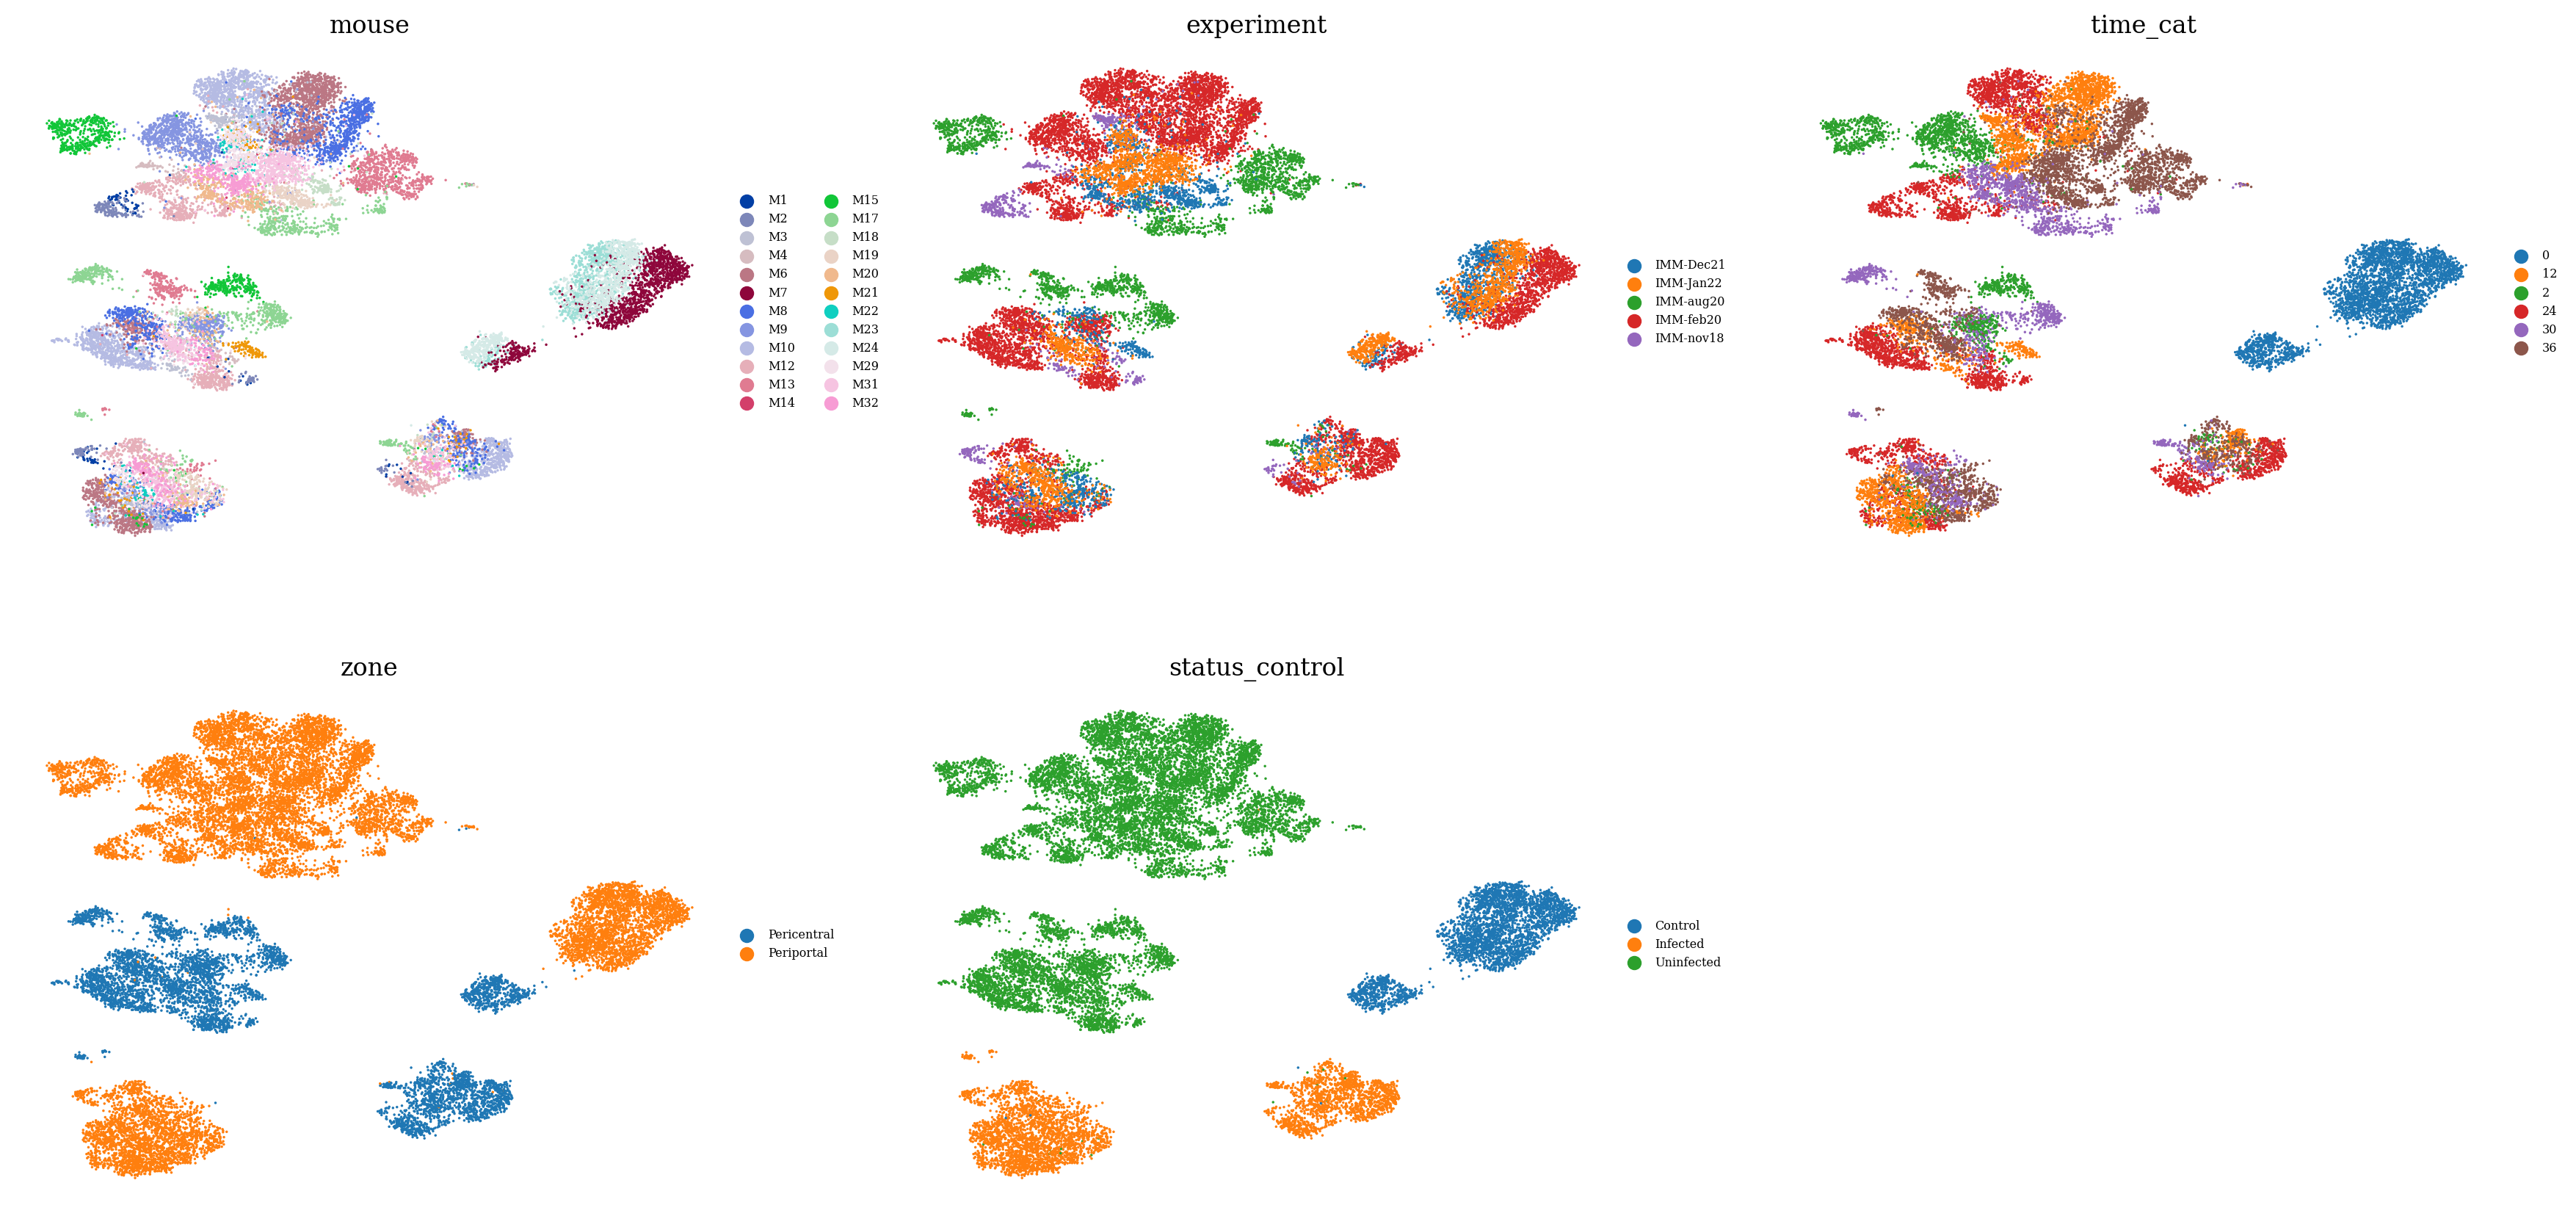

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

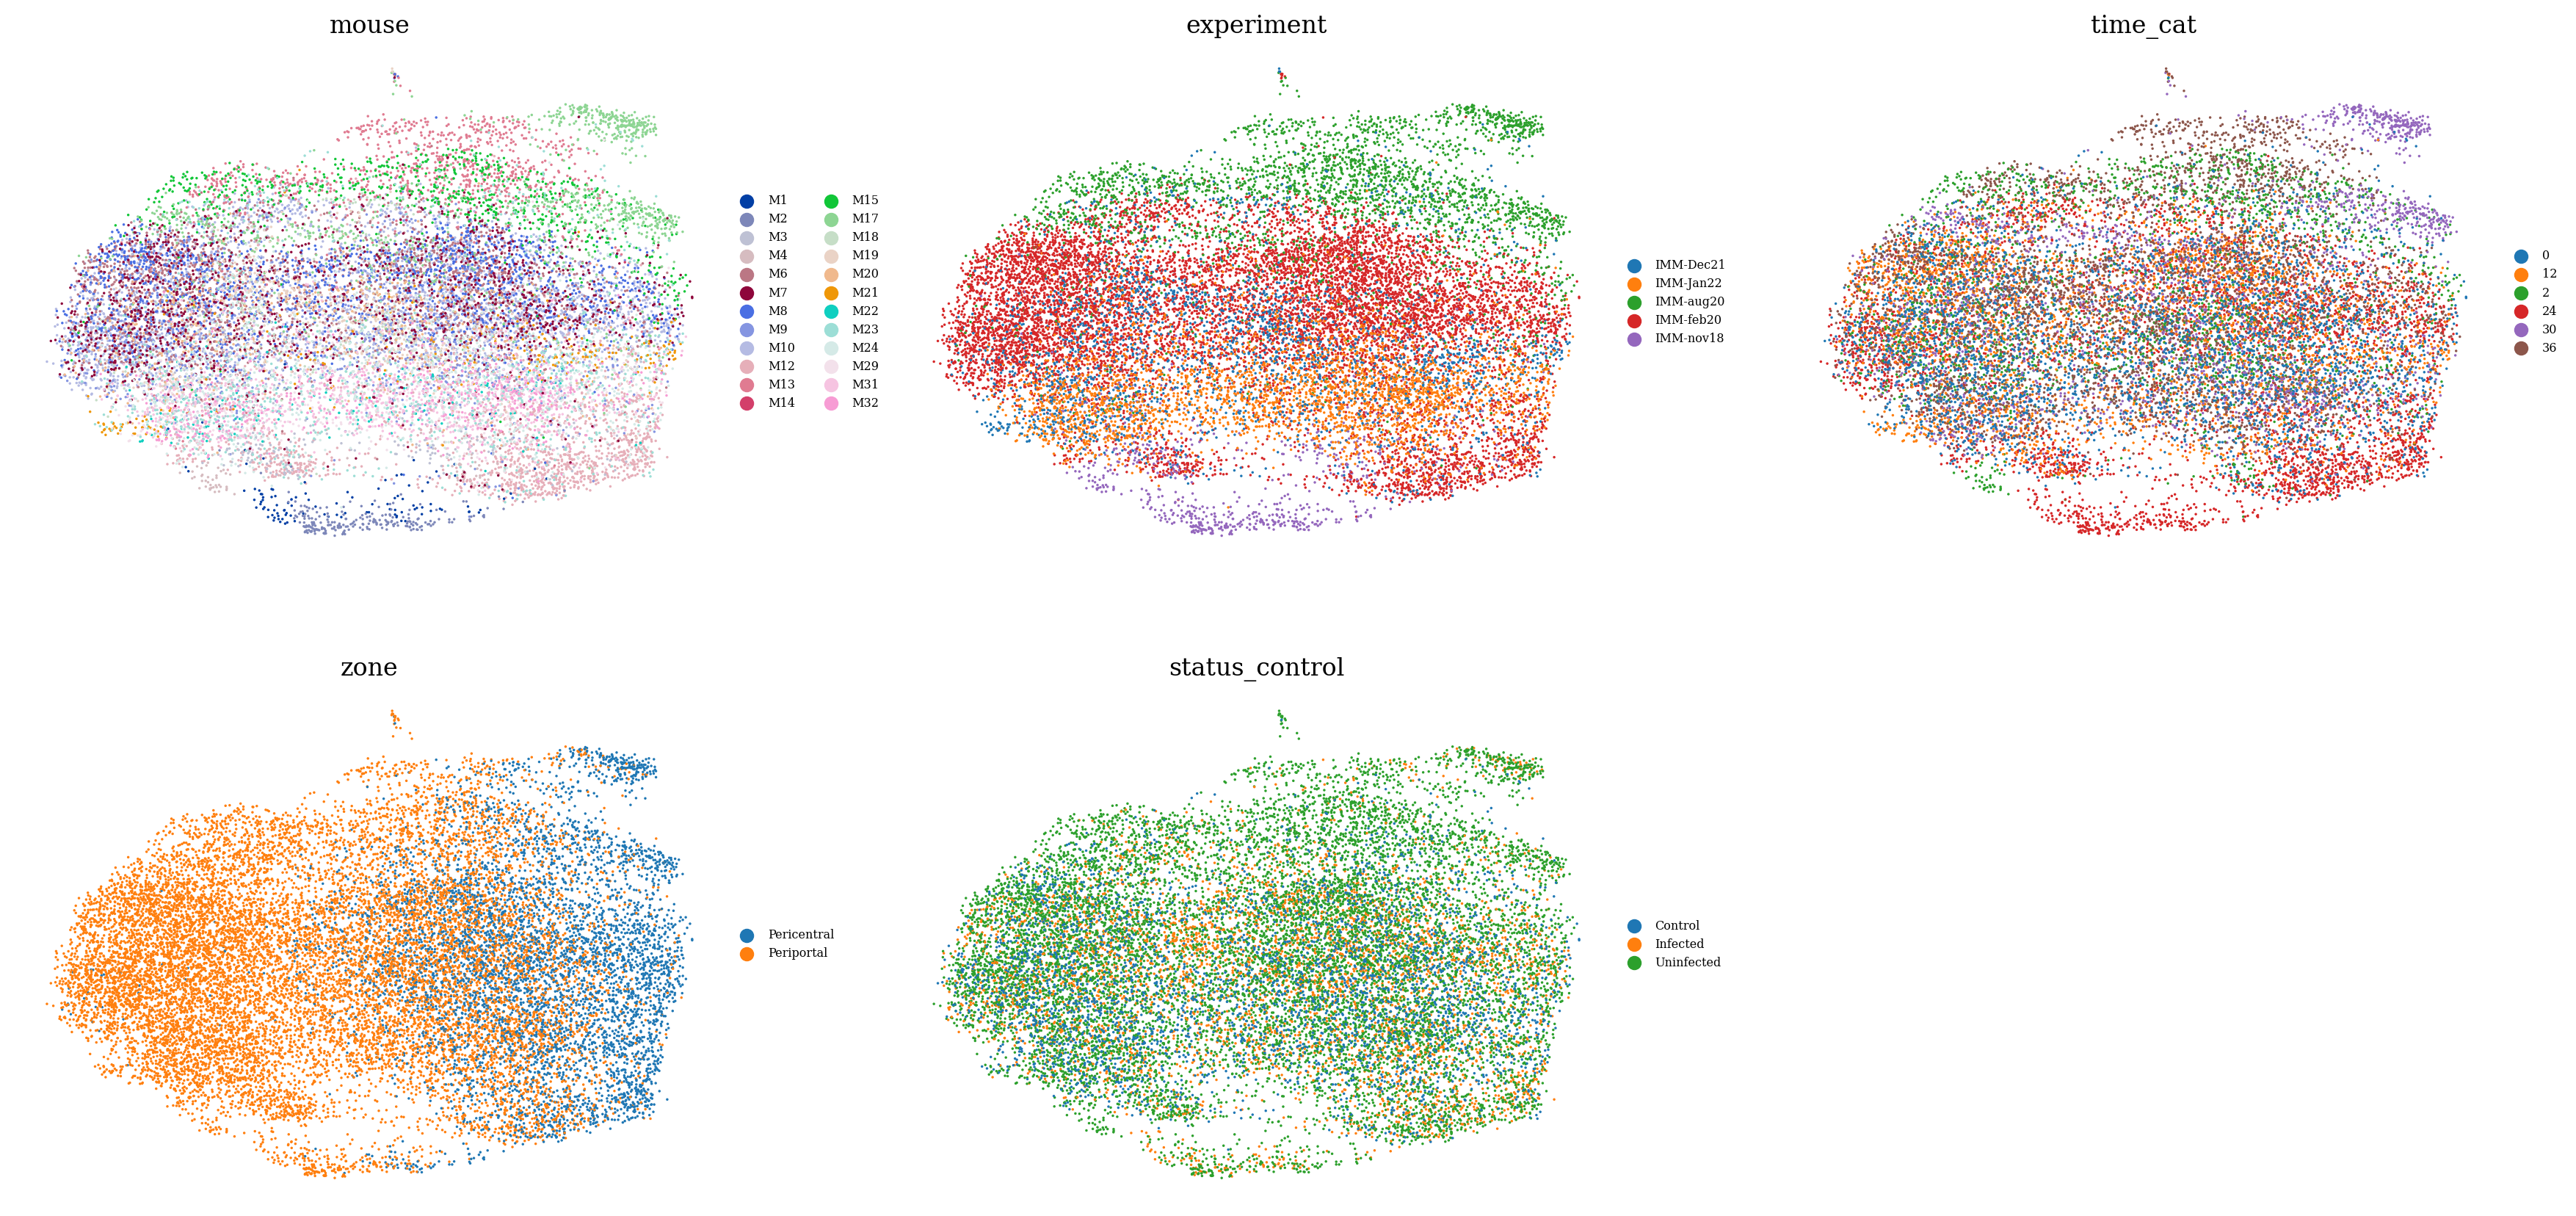

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  0%|          | 1/596 [00:00<03:33,  2.78it/s]

  0%|          | 2/596 [00:00<03:30,  2.82it/s]

  1%|          | 3/596 [00:01<03:29,  2.83it/s]

  1%|          | 4/596 [00:01<03:29,  2.83it/s]

  1%|          | 5/596 [00:01<03:28,  2.83it/s]

  1%|          | 6/596 [00:02<03:21,  2.92it/s]

  4%|▍         | 24/596 [00:02<00:23, 24.83it/s]

  7%|▋         | 44/596 [00:02<00:10, 50.85it/s]

 11%|█         | 63/596 [00:02<00:07, 74.73it/s]

 13%|█▎        | 79/596 [00:02<00:05, 90.90it/s]

 17%|█▋        | 100/596 [00:02<00:04, 116.58it/s]

 20%|██        | 120/596 [00:02<00:03, 136.00it/s]

 23%|██▎       | 140/596 [00:02<00:03, 151.90it/s]

 27%|██▋       | 161/596 [00:02<00:02, 165.20it/s]

 30%|███       | 181/596 [00:03<00:02, 174.56it/s]

 34%|███▎      | 200/596 [00:03<00:02, 177.26it/s]

 37%|███▋      | 220/596 [00:03<00:02, 182.81it/s]

 40%|████      | 240/596 [00:03<00:01, 186.78it/s]

 44%|████▎     | 260/596 [00:03<00:01, 189.63it/s]

 47%|████▋     | 280/596 [00:03<00:01, 191.54it/s]

 50%|█████     | 300/596 [00:03<00:01, 193.26it/s]

 54%|█████▎    | 320/596 [00:03<00:01, 194.10it/s]

 57%|█████▋    | 340/596 [00:03<00:01, 194.77it/s]

 60%|██████    | 360/596 [00:03<00:01, 194.77it/s]

 64%|██████▍   | 380/596 [00:04<00:01, 195.10it/s]

 67%|██████▋   | 400/596 [00:04<00:01, 195.17it/s]

 70%|███████   | 420/596 [00:04<00:00, 194.99it/s]

 74%|███████▍  | 440/596 [00:04<00:00, 195.26it/s]

 77%|███████▋  | 460/596 [00:04<00:00, 195.57it/s]

 81%|████████  | 480/596 [00:04<00:00, 195.67it/s]

 84%|████████▍ | 500/596 [00:04<00:00, 195.79it/s]

 87%|████████▋ | 520/596 [00:04<00:00, 196.54it/s]

 91%|█████████ | 540/596 [00:04<00:00, 196.86it/s]

 94%|█████████▍| 560/596 [00:04<00:00, 196.74it/s]

 97%|█████████▋| 580/596 [00:05<00:00, 197.08it/s]

100%|██████████| 596/596 [00:05<00:00, 116.01it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

In [23]:
np.mean(r2s)

0.9817081755999653

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)